Bias correct the hail predictor variables from ERA5 and LENS2 using quantile-quantile mapping.  

The bias correct is per grid point and use a 31-day running window. 
This is the 1st part using the Replace mapping for current climate and I will use Delta QM for future climate.
- Grid/Temporal interopolation/aligment
- For each model value, get its percentile on the CDF of the model,then apply it to get a value from the reference ERA5 dataset.
- Bias Adjustment: Replacing it by the corresponding value from reference ERA5 dataset. This is done for each time step and grid point.
- Validation: Assess the effectiveness of the bias correction by comparing the corrected CESM data against ERA5 data over a separate validation period (if available). Check statistical measures such as mean bias, root mean square error (RMSE), and correlation coefficient. (not done yet)

Reference:
 - Technical Note: Bias correcting climate model simulated daily temperature extremes with quantile mapping <br>
https://hess.copernicus.org/articles/16/3309/2012/hess-16-3309-2012.pdf
- Quantile Mapping Bias Correction <br>
https://medium.com/@juanmi.gutierrez/quantile-mapping-bias-correction-63ed01d5a618#:~:text=Quantile%20mapping%20works%20by%20removing,adjusting%20the%20forecast%2Fprojection%20values
- Explain Quantile Mapping Bias Correction with Python code
https://www.linkedin.com/pulse/explain-quantile-mapping-bias-correction-python-code-chonghua-yin

Ming Ge Aug. 2024

In [1]:
import numpy
import datetime
import os
import glob
from calendar import isleap
from tqdm import tqdm
from netCDF4 import Dataset
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import norm, gamma, erlang, expon
from scipy.stats import percentileofscore
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
def bias_correction_current(ref_dataset, model_present):
    '''
    Remove the biases for each quantile value taking the difference between 
    ref_dataset and model_present at each percentile as a kind of systematic bias (delta)
    and add them to model_future at the same percentile.

    returns: downscaled model_present  
    '''
    model_present_corrected = np.zeros(model_present.size)
    #print(ref_dataset.shape)
    print(model_present)
    for ival, model_value in enumerate(model_present):
        percentile = percentileofscore(model_present, model_value, nan_policy = 'omit')
        #print(ival, percentile)
        if np.isnan(percentile):
            model_present_corrected[ival] = np.nan
        else:
            if percentile >100:
                print(percentile)
                #print('--', ref_dataset, '--')
                model_present_corrected[ival] = ref_dataset.max()
            elif percentile == 0:
                model_present_corrected[ival] = ref_dataset.min()
            else:
                #print('--', ref_dataset[:3], percentile)
                model_present_corrected[ival] = np.nanpercentile(ref_dataset, percentile)
                #print(model_present_corrected[ival], 'aaaaa')
    #print(model_present_corrected )
    return model_present_corrected 


In [3]:
def bias_correction_current_my(ref_dataset, model_present, value):
    '''
    The BC uses a base period where both observations and simulated values are
available.
    ref_dataset: data from candidate days representative of the date of the value
    model_present: data from candidate days representative of the date of the value
    value: 
    return bias corrected value
    '''
    # using the CDF of the model to determine the quantile associated with the value
    percentile = percentileofscore(model_present, value, nan_policy = 'omit')

    #  drawing the reference value from that same day’s CDF for the same quantile. 
    if np.isnan(percentile):
        bc_corrected = np.nan
    else:
        if percentile >100:
            bc_corrected = ref_dataset.max()
        elif percentile == 0:
            bc_corrected = ref_dataset.min()
        else:
            bc_corrected = np.nanpercentile(ref_dataset, percentile)
                
    return bc_corrected 

#### setups

In [4]:
year_s = 1960
year_e = 2014
n_year = year_e - year_s + 1

time_1d = pd.date_range(datetime.datetime(year_s, 1, 1, 0),
                     end=datetime.datetime(year_e, 12, 31, 23), freq='d')
time_6h = pd.date_range(datetime.datetime(year_s, 1, 1, 0),
                     end=datetime.datetime(year_e, 12, 31, 23), freq='6h')
n_day = len(time_1d)

# variables from ERA5
# /glade/u/home/prein/projects/2024/2024_ML-Hail-Model/programs/    Boris_code  LENS2_evaluation
# from /glade/u/home/prein/projects/2023/2023_Boris-Hail/programs
dir_cmp = '/glade/campaign/mmm/c3we/prein/Projects/2023_Hail-Update/Boris_scrach/ERA5_hail_model/ERA5-hailpredictors/'
lens2_datadir = '/glade/campaign/mmm/c3we/mingge/LENS2/6hr/'
sERAconstantFields ='/glade/campaign/mmm/c3we/prein/Projects/2023_Hail-Update/Boris_scrach/ERA5_hail_model/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc'
dir_lens2 = '/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/hour_6/'
dir_o     = '/glade/campaign/mmm/c3we/mingge/QBE/'

# no leap year
time_1d_nl = time_1d[(time_1d.month != 2) | (time_1d.day != 29)]
time_6h_nl = time_6h[(time_6h.month != 2) | (time_6h.day != 29)]
n_day_nl = int(len(time_6h_nl)/4)

years = np.unique(time_6h.year)
iMonths = np.unique(time_6h.month)


#### Read LENS2 variables

In [5]:
with xr.open_dataset(lens2_datadir+'2010010100-2014123100_LENS2_HailPredictors_010.nc') as ds:
    lon_lens_1d = np.array(ds["lon"])
    lat_lens_1d = np.array(ds["lat"])
    
n_lat_lens = len(lat_lens_1d)
n_lon_lens = len(lon_lens_1d)
lon_lens, lat_lens = np.meshgrid(lon_lens_1d, lat_lens_1d)

lens_var_names = ['CAPEmax',
                'FLH',
                'CINmax',
                'VS06',
                'TotalTotal',
                'RH850']
n_var = len(lens_var_names)

In [8]:
%%time
# slow for 10 members. 1 member 2min 34s, 10 member 51min
n_mem = 10

lens_vars = np.zeros((len(time_6h_nl), n_lat_lens, n_lon_lens, n_var, n_mem))
lens_vars[:] = np.nan

for yy in range(n_year):
    for nm in range(n_mem):
        # find the correct file for this year
        file = glob.glob(lens2_datadir+str(years[yy])[:3]+'0010100-*_LENS2_HailPredictors_'+str(nm+1).zfill(3)+'.nc')[0]
        time_file = pd.date_range(datetime.datetime(int(file.split('/')[-1][:4]), 1, 1, 0),
                         end=datetime.datetime(int(file.split('/')[-1][11:15]), 12, 31, 23), freq='6h')
        # remove leap year
        time_file = time_file[(time_file.month != 2) | (time_file.day != 29)]
     
        data_loc_sor = time_file.year == years[yy]
        data_loc_tar = time_6h_nl.year == years[yy]
         
        ncid=Dataset(file, mode='r')
        for va in range(len(lens_var_names)):
            lens_vars[data_loc_tar,:,:,va,nm] = np.squeeze(ncid.variables[lens_var_names[va]][:len(data_loc_sor),:,:][data_loc_sor,:,:])
        ncid.close()

CPU times: user 3min 15s, sys: 20min 50s, total: 24min 5s
Wall time: 50min 52s


In [9]:
%%time
#7min
# get daily values by picking the max CAPE time
lens_vars = np.reshape(lens_vars, 
           (n_day_nl, 4, n_lat_lens, n_lon_lens, n_var, n_mem))
            
lens_daymax = np.copy(lens_vars[:,0])
lens_daymax[:] = np.nan

t,i,j = np.indices(lens_vars[:,0,:,:,0,0].shape)
for nm in range(n_mem):
    for va in range(n_var):
        if lens_var_names[va] == 'CAPEmax':
            argmax_indices = np.argmax(lens_vars[:,:,:,:,va,nm], axis=1)
        lens_daymax[:,:,:,va, nm] = lens_vars[t,argmax_indices,i,j,va, nm]

# replace CIN NANs with zeros
lens_daymax[:,:,:,lens_var_names.index('CINmax'),:][np.isnan(lens_daymax[:,:,:,lens_var_names.index('CINmax'),:])] = 0

CPU times: user 2min 12s, sys: 3min 45s, total: 5min 58s
Wall time: 7min 1s


#### Read and remap ERA5 hail predictors to LENS2 grid

In [10]:
# Save Latitude, Longitude and Height in arrays
rgsERAdata = '/glade/campaign/mmm/c3we/prein/Projects/2023_Hail-Update/Boris_scrach/ERA5_hail_model/'
sERAconstantFields = '/glade/campaign/mmm/c3we/prein/Projects/2023_Hail-Update/Boris_scrach/ERA5_hail_model/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc'
ncid = Dataset(sERAconstantFields, mode='r')
lat_era = np.squeeze(ncid.variables['latitude'][:])
lon_era = np.squeeze(ncid.variables['longitude'][:])
rgrHeight = (np.squeeze(ncid.variables['Z'][:,:,:]))/9.81
ncid.close()

lon_era, lat_era = np.meshgrid(lon_era, lat_era)

# find CONUS in ERA5
era_w = np.where(lon_lens[0,0] <= lon_era[0,:])[0][0]
era_e = np.where(lon_lens[0,-1] <= lon_era[0,:])[0][0]
era_n = np.where(lat_lens[0,0] >= lat_era[:,0])[0][0]
era_s = np.where(lat_lens[-1,0] >= lat_era[:,0])[0][0]

lat_era = lat_era[era_s:era_n, era_w:era_e]
lon_era = lon_era[era_s:era_n, era_w:era_e]

In [11]:
%%time
# 16 s
rgrERAVarall=np.zeros((n_day_nl, n_var, n_lat_lens, n_lon_lens))
iyear=0
 
for yy in range(n_year):
    iday=0
    outfile = '/glade/campaign/mmm/c3we/prein/Projects/2023_Hail-Update/QBE/data_on_LENS2/ERA5_LENS2_predictors_' + str(years[yy])+'.npz'
    yearlength=365 + isleap(years[yy])
    
    if os.path.isfile(outfile) == False:
        rgrERAVarsyy=np.zeros((yearlength, n_var, n_lat_lens, n_lon_lens))

        #Loop over months
        for mm in range(len(iMonths)):
            # __________________________________________________________________
            # start reading the ERA data
            dDate=time_1d[0]
            monthlength=int(monthrange(years[yy],mm+1)[1])
            rgrERAdataAll=np.zeros((monthlength*24, n_var, n_lat_lens, n_lon_lens))
            rgrERAdataAll[:]=np.nan
           
            # loop over variables
            for va in range(len(lens_var_names)):
                if lens_var_names[va] in ['CAPEmax', 'VS03', 'SRH03', 'FLH']:
                    sFileName=rgsERAdata + 'ERA5-hailpredictors/' + str(years[yy])+str("%02d" % (mm+1))+'_ERA-5_HailPredictors_newSRH03.nc'
                    ncid=Dataset(sFileName, mode='r')
                else:
                    sFileName=rgsERAdata + 'ERA5-hailpredictors/' + str(years[yy])+str("%02d" % (mm+1))+'_New_RH_TT.nc'
                    ncid=Dataset(sFileName, mode='r')

                rgrDataTMP = np.squeeze(ncid.variables[lens_var_names[va]][:,era_s:era_n, era_w:era_e])

                dfDataDest = np.zeros((rgrDataTMP.shape[0], n_lat_lens, n_lon_lens))

                DATA_TarGrid = fnCDOregrid(rgrDataTMP,
                                            lon_era,
                                            lat_era,
                                            dfDataDest,
                                            lon_lens,
                                            lat_lens,
                                            sRemapMeth='remapcon')
                
                rgrERAdataAll[:,lens_var_names.index(lens_var_names[va]),:,:]=DATA_TarGrid
                ncid.close()  

            #reshaping the monthly data into daily data to be able to extract the daily max CAPE
            dayrgrERAdataAll=rgrERAdataAll.reshape(int(monthlength), 24, n_var, n_lat_lens, n_lon_lens)

            # take the time of maximum CAPE
            timemax=np.argmax(dayrgrERAdataAll[:,:,0,:,:],axis=1) 
            timemax2=np.zeros((int(monthlength), 24, n_var, n_lat_lens, n_lon_lens))
            timemax2[:,:,:,:,:]=timemax[:,None,None,:]
            timemax2=timemax2.astype(int)

            #Take the predictors at the time of max CAPE for each day
            rgrERAVars=np.take_along_axis(dayrgrERAdataAll,timemax2,axis=1)
            rgrERAVars=rgrERAVars[:,1,:,:,:]
            
            #save monthly data in a yearly array
            rgrERAVarsyy[iday:iday+monthlength,:,:,:]=rgrERAVars

            iday=monthlength+iday
        np.savez(outfile,
                rgrERAVarsyy = rgrERAVarsyy,
                lat_lens = lat_lens,
                lon_lens = lon_lens,
                time_1d = time_1d)
        #save the yearly data in an array containing the whole period
        rgrERAVarall[iyear:iyear+yearlength,:,:,:]=rgrERAVarsyy
        iyear=iyear+yearlength
    else:
        # remove leap day
        #print ('The file already exists:', outfile)
        data_tmp = np.load(outfile)
        if isleap(years[yy]):
            rgrERAVarall[iyear:iyear+365,:,:,:] = np.delete(data_tmp['rgrERAVarsyy'], 60, 0)
        else:    
            rgrERAVarall[iyear:iyear+365,:,:,:] = data_tmp['rgrERAVarsyy']
        lat_lens = data_tmp['lat_lens']
        lon_lens = data_tmp['lon_lens']
        #time_1d = pd.to_datetime(data_tmp['time_1d'])
        iyear=iyear+365

# replace CIN NANs with zeros
rgrERAVarall[:,lens_var_names.index('CINmax'),:,][np.isnan(rgrERAVarall[:,lens_var_names.index('CINmax'),:,:])] = 0

CPU times: user 1.75 s, sys: 11.9 s, total: 13.6 s
Wall time: 24.5 s


#### Preparing BC with quantile mapping

In [13]:
%%time
# 1h 11s
# For each day of the year, a moving window of ±15 days is used 
# to select all candidate days representative of the date, 
# The following part is too time consumming, I leave it to a array job
# of python script:
# and then all of these candidate days are sorted and ranked to produce 
# (for each calendar day) two cumulative distribution functions (CDFs):
# one for observations and one for the GCM. 
# A bias-corrected value for a LENS2 daily value is retrieved by using 
# the CDF distribution for the LENS2 to determine the quantile associated
# with the value, and then drawing the ERA5 value from that same day’s CDF 
# for the same quantile 

window_size = 31
win_half = 15
win_half_p1 =  window_size - win_half

for nm in range(n_mem):
    mem_s = str(nm+1).zfill(2)
    print('member', mem_s)
    flnm_o = dir_o + 'hailpredictors_lens_31window_' + mem_s + '.nc'
    if os.path.isfile(flnm_o) == False:
        # creat an array of nan
        lens_daymax_31window = np.full((n_day_nl, window_size, n_lat_lens, n_lon_lens, n_var), np.nan)

        for nt in range(n_day_nl):
            if nt < win_half:
                lens_daymax_31window[nt, 31-nt-win_half_p1:] = lens_daymax[:nt+win_half_p1, :,:, :,nm]
            elif nt > n_day_nl - win_half_p1:
                lens_daymax_31window[nt, :n_day_nl-nt + win_half] = lens_daymax[nt-win_half:, :,:, :, nm]
            else:
                lens_daymax_31window[nt,:] = lens_daymax[nt-win_half:nt+win_half_p1, :,:, :, nm]

        lens_31window = np.reshape(lens_daymax_31window, (n_year, 365, window_size, n_lat_lens, n_lon_lens, n_var))
        da_lens = xr.DataArray(lens_31window, coords=[np.arange(year_s, year_e+1, 1), 
                                                 np.arange(1, 366,1),
                                                 np.arange(1,window_size+1, 1),
                                                 lat_lens_1d,
                                                 lon_lens_1d,
                                                 lens_var_names],
                       dims=['year', 'Julian_day', 'window', 'lat', 'lon', 'variable'])

        ds = da_lens.to_dataset(name='hailpredictors')
        ds.to_netcdf(path = flnm_o)
        print(flnm_o)
    
#lens_data = np.reshape(lens_daymax, (n_year, 365, n_lat_lens, n_lon_lens, n_var, n_mem))

member 01
/glade/campaign/mmm/c3we/mingge/QBE/hailpredictors_lens_31window_01.nc
member 02
/glade/campaign/mmm/c3we/mingge/QBE/hailpredictors_lens_31window_02.nc
member 03
/glade/campaign/mmm/c3we/mingge/QBE/hailpredictors_lens_31window_03.nc
member 04
/glade/campaign/mmm/c3we/mingge/QBE/hailpredictors_lens_31window_04.nc
member 05
/glade/campaign/mmm/c3we/mingge/QBE/hailpredictors_lens_31window_05.nc
member 06
/glade/campaign/mmm/c3we/mingge/QBE/hailpredictors_lens_31window_06.nc
member 07
/glade/campaign/mmm/c3we/mingge/QBE/hailpredictors_lens_31window_07.nc
member 08
/glade/campaign/mmm/c3we/mingge/QBE/hailpredictors_lens_31window_08.nc
member 09
/glade/campaign/mmm/c3we/mingge/QBE/hailpredictors_lens_31window_09.nc
member 10
/glade/campaign/mmm/c3we/mingge/QBE/hailpredictors_lens_31window_10.nc
CPU times: user 4min 22s, sys: 26min 16s, total: 30min 39s
Wall time: 1h 11s


In [15]:
%%time

flnm_o = dir_o + 'hailpredictors_e5_31window.nc'
if os.path.isfile(flnm_o) == False:
    # creat an array of nan
    e5_daymax_31window = np.full((n_day_nl, window_size, n_var, n_lat_lens, n_lon_lens), np.nan)

    for nt in range(n_day_nl):
        if nt < win_half:
            e5_daymax_31window  [nt, 31-nt-win_half_p1:] = rgrERAVarall[:nt+win_half_p1]
        elif nt > n_day_nl - win_half_p1:
            e5_daymax_31window  [nt, :n_day_nl-nt + win_half] = rgrERAVarall[nt-win_half:]
        else:
            e5_daymax_31window[nt,:] = rgrERAVarall[nt-win_half:nt+win_half_p1]

    e5_31window = np.reshape(e5_daymax_31window, (n_year, 365, window_size, n_var, n_lat_lens, n_lon_lens))

    da_e5 = xr.DataArray(e5_31window, coords=[np.arange(year_s, year_e+1, 1), 
                                                 np.arange(1, 366,1),
                                                 np.arange(1,window_size+1, 1),
                                                 lens_var_names,
                                                 lat_lens_1d,
                                                 lon_lens_1d],
                       dims=['year', 'Julian_day', 'window', 'variable', 'lat', 'lon'])

    ds = da_e5.to_dataset(name='hailpredictors')
    ds.to_netcdf( path = flnm_o)
    print(flnm_o)
else:
    with xr.open_dataset(flnm_o) as ds:
        e5_31window = ds.hailpredictors
#plt.pcolormesh(lon_lens, lat_lens, da_e5[0,0,15,0,:,:].data,vmin=0, vmax=1400 ) 

CPU times: user 11.9 ms, sys: 4.88 ms, total: 16.8 ms
Wall time: 48.9 ms


#### bias correction

#### Check corrected dataset

In [7]:
flnm_cre = dir_o + 'hailpredictors_lens_01_corrected.nc'
flnm_org = '/glade/campaign/mmm/c3we/mingge/QBE/hailpredictors_lens_31window_01.nc'
# I radomly chose 1961  Julian day = 201
with xr.open_dataset(flnm_org) as ds:
    data_1 = ds.hailpredictors[1,200,15,:,:,:]
    #data_1[:,:,5].plot(vmin=0, vmax=100)
    #plt.show()
with xr.open_dataset(flnm_cre) as ds:
    data_2 = ds.hailpredictors[1,200,:,:,:]
    #data_2[:,:,5].plot(vmin=0, vmax=100)

# Stack the arrays along a new dimension (axis=0)
stacked_data = np.stack((data_1.data, data_2.data), axis=0)
stacked_data.shape

(2, 28, 48, 6)

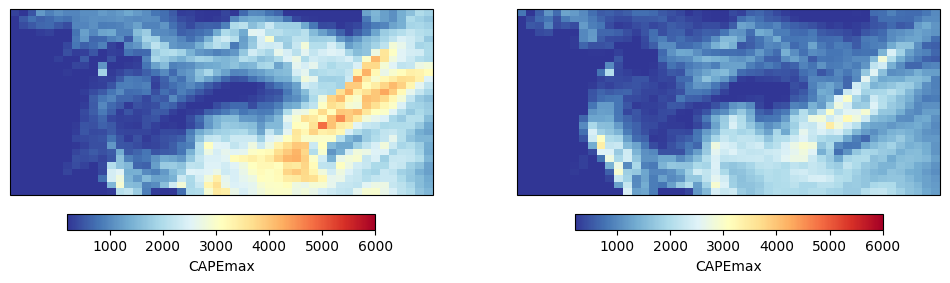

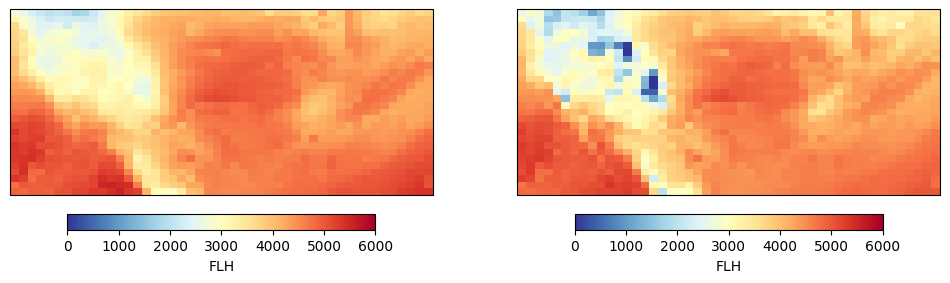

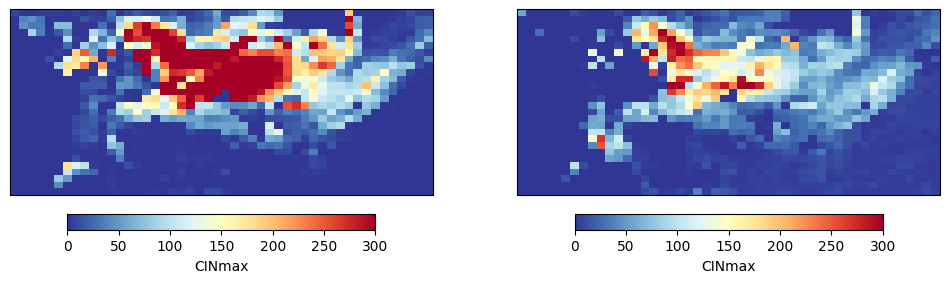

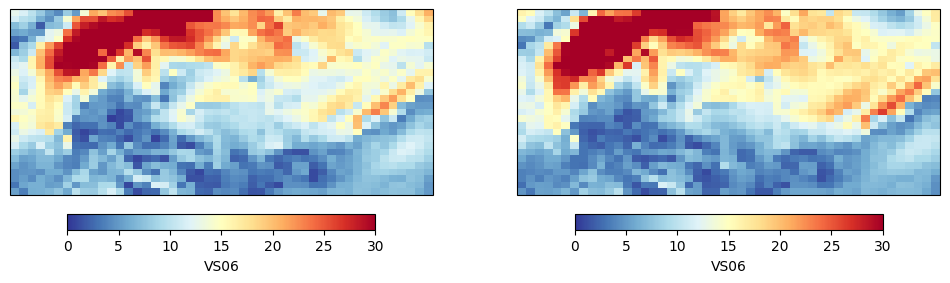

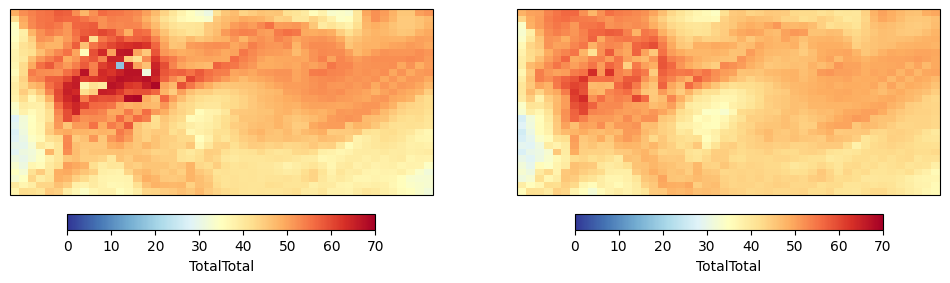

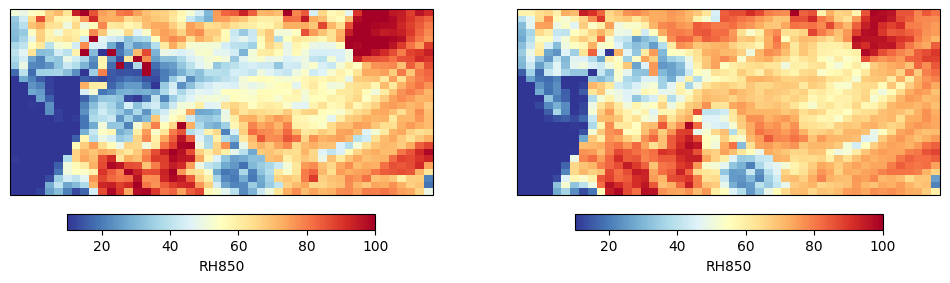

In [8]:
def plot_mesh_p2(lat, lon, data, color_map, var_s, vmin, vmax):
    
    fig, ax = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()},
                          figsize=(12, 5))
    title_s = ['before BC', 'after BC']
    for nn in range(2):
        # Make a filled contour plot
        ''' 
        filled_c = ax[nn].contourf(lon, lat, data[nn],
                           extend='both', levels =np.arange(vmin, vmax, (vmax-vmin)/10), 
                           cmap = color_map, transform = ccrs.PlateCarree())       
        
        ax[nn].coastlines()
        ax[nn].add_feature(cfeature.STATES, zorder=1, linewidth=.3, edgecolor='black')
        ax[nn].set_title(title_s[nn])
        ax[nn].set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())
        ax[nn] = plt.gca()
        
        # Add a colorbar for the filled contour.
        # and pad argument to set colorbar away from x-axis
        fig.colorbar(filled_c,  label= var_s, pad = 0.05, fraction=0.04, orientation="horizontal"); 
        #fig.colorbar(filled_c,   shrink=0.9, orientation="horizontal")
        '''
        im = ax[nn].pcolormesh(lon, lat, data[nn], vmin = vmin, vmax = vmax, cmap=color_map, shading='auto',rasterized=True)
        fig.colorbar(im,ax=ax[nn],  label= var_s, pad = 0.05, fraction=0.04, orientation="horizontal")
        
vmin = [200,    0,  0,   0,  0,   10 ]
vmax = [6000, 6000, 300, 30, 70, 100]
for nv in range(n_var):
    plot_mesh_p2(ds.lat, ds.lon, stacked_data[:,:,:,nv], 'RdYlBu_r', lens_var_names[nv], vmin[nv], vmax[nv])
    